In [112]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision.models import resnet34, ResNet34_Weights
from tqdm import tqdm 
import pandas as pd
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score


np.random.seed(42)
cudnn.benchmark = True
plt.ion()   # interactive mode
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
device = torch.device('mps')

In [114]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/train_images'

## Load data

### Train and validation set

In [115]:
train_dataset = datasets.ImageFolder(
    './data/train_images', 
    transform=data_transforms['train'], 
)
val_dataset = datasets.ImageFolder(
    './data/train_images',
    transform=data_transforms['val']
)

num_classes = len(train_dataset.classes)
num_dataset = len(train_dataset)


# split dataset
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
num_val = split
num_train = len(train_dataset) - num_val
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
print('Number of train samples:', len(train_indices))
print('Number of val samples:', len(val_indices))

Number of train samples: 8326
Number of val samples: 2081


In [116]:
print(valid_sampler.indices)

[3952, 4597, 9621, 8620, 4294, 3912, 4582, 5657, 2340, 1702, 3319, 6464, 6711, 9563, 518, 1730, 318, 6888, 10264, 4031, 9374, 5157, 1576, 5527, 4842, 35, 4681, 39, 3463, 4818, 673, 932, 8525, 2412, 668, 9399, 1623, 9483, 1683, 4394, 3130, 2270, 1247, 5736, 1368, 2846, 7478, 3963, 8291, 3921, 1981, 3755, 8603, 5292, 9596, 2680, 8309, 8332, 6545, 1780, 33, 8303, 2233, 7199, 3070, 8318, 3021, 3127, 6192, 9408, 7845, 4161, 1121, 4609, 5414, 6151, 4115, 6690, 4700, 8862, 7563, 5159, 5206, 10002, 6883, 3047, 1740, 9746, 3794, 3100, 4759, 9809, 457, 5304, 592, 5667, 4091, 9194, 3914, 5389, 2992, 10050, 4170, 6119, 1511, 9340, 2152, 8963, 7095, 7997, 4284, 5573, 1512, 2826, 1297, 8030, 8237, 6568, 4121, 9528, 10285, 8709, 2926, 6696, 1536, 8852, 3621, 2602, 533, 5683, 5682, 9373, 5865, 6321, 9240, 8327, 6414, 3166, 9814, 2522, 8572, 6398, 4812, 251, 2886, 1766, 7924, 2320, 6661, 6785, 8287, 5361, 9862, 5153, 1791, 5129, 2287, 10009, 1180, 1056, 9433, 8903, 3316, 119, 9910, 6394, 3704, 311, 794

In [117]:
print(next(iter((train_loader)))[0].shape)
print(len(train_loader))

torch.Size([32, 3, 256, 256])
261


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


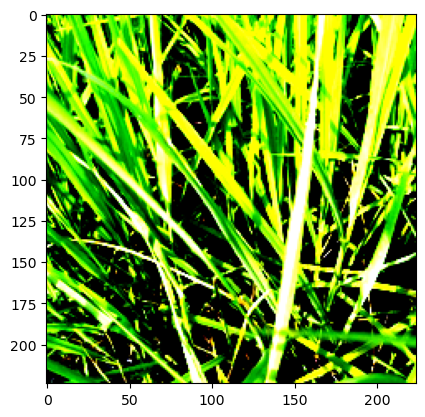

In [118]:
def show_image(img): 
    plt.imshow(img.permute(1, 2, 0))
def show_dataset(dataset): 
    img = dataset[0][0].permute(1, 2, 0)
    plt.imshow(img)

show_dataset(val_dataset)

### Test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


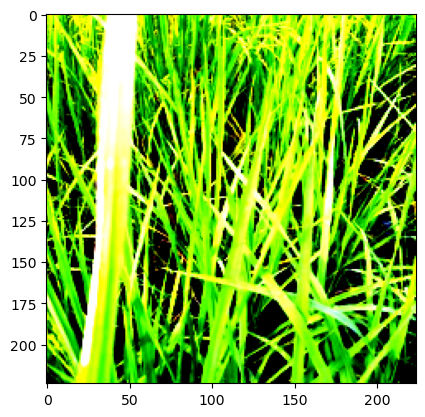

In [119]:
import os
from PIL import Image
test_path = './data/test_images'

class CustomTestDataset(Dataset): 
    def __init__(self, img_dir, transform=None) -> None:
        super().__init__()
        self.img_dir = img_dir
        self.transform = transform
        self.files_list = sorted(os.listdir(img_dir))
        
    def __len__(self): 
        return len(self.files_list)
        
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.img_dir, self.files_list[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image
test_dataset = CustomTestDataset(test_path, data_transforms['val'])
test_dataloader = DataLoader(test_dataset, batch_size)
print(test_dataset[0].shape)
plt.imshow(test_dataset[0].permute(1, 2, 0))

## Model

### Initialize model

In [120]:
class CustomResNet34(nn.Module): 
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        
        self.resnet34 = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.resnet34 = nn.Sequential(*list(self.resnet34.children())[:-1])
        self.lin = nn.Linear(512, num_classes)
    
    def forward(self, x): 
        x: torch.Tensor = self.resnet34(x)
        x = self.lin(x.reshape(x.shape[0], -1))
        assert x.shape[-1] == num_classes, f'Wrong shape for x({x.shape})'
        return x

model = CustomResNet34(num_classes).to(device)

In [121]:
count = 0
for b in tqdm(model.parameters()):
    count+= 1

110it [00:00, 523692.89it/s]


In [122]:
count

110

In [123]:
model

CustomResNet34(
  (resnet34): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

### Train model

In [124]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss(reduction='sum').to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)

In [125]:
def accuracy_softmax(out, targets): 
    with torch.no_grad(): 
        pred = torch.argmax(nn.functional.softmax(out, dim=-1), -1)
        acc = accuracy_score(targets.tolist(), pred.tolist())
    return acc

In [126]:
def validate_one_epoch(dataloader: DataLoader): 
    total_loss = 0
    model.eval()
    avg_batches_acc = 0
    for batch, targets in tqdm(dataloader, leave=False): 
        
        with torch.no_grad(): 
            out = model.forward(batch.to(device))
            loss = criterion.forward(out, targets.to(device))
            total_loss += loss
            batch_acc = accuracy_softmax(out, targets)
            avg_batches_acc += batch_acc
    avg_batches_acc /= len(dataloader)
    return total_loss, avg_batches_acc

In [127]:
num_epochs = 3

iters = len(train_loader)
for epoch in range(num_epochs): 
    print(f'Epoch: {epoch+1}')
    total_loss = 0
    i = 0
    avg_train_acc = 0
    for batch, targets in tqdm(train_loader): 
        model.train()
        # Forward
        out = model.forward(batch.to(device)) # shape: (batch_size, 10)
        loss = criterion.forward(out, targets.to(device))
        
        total_loss += loss.item()
        # Compute the loss and its gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Adjust learning rate
        scheduler.step(epoch + i / iters)
        i += 1
        # Compute train accuracy
        batch_acc = accuracy_softmax(out, targets)
        avg_train_acc += batch_acc
    avg_train_acc /= iters
    # validate 
    val_loss, avg_batches_acc = validate_one_epoch(val_loader)
        
    print(f'train loss: {total_loss/iters} || train acc: {avg_train_acc*100}%')
    print(f'Val loss: {val_loss/len(val_loader)} || val acc: {avg_batches_acc*100}%')

Epoch: 1


100%|██████████| 261/261 [01:17<00:00,  3.36it/s]


train loss: 50.14006357083375 || train acc: 46.024904214559385%
Val loss: 36.178043365478516 || val acc: 59.185606060606055%
Epoch: 2


100%|██████████| 261/261 [01:17<00:00,  3.38it/s]


train loss: 37.96829190016706 || train acc: 58.95593869731801%
Val loss: 39.97460174560547 || val acc: 59.327651515151516%
Epoch: 3


 25%|██▌       | 66/261 [00:19<00:57,  3.40it/s]


KeyboardInterrupt: 

In [ ]:
print(len(train_dataset.classes))
print(train_dataset.classes)

10
['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [ ]:
preds = []
for batch in tqdm(test_dataloader): 
    with torch.no_grad(): 
        out = model.forward(batch.to(device))
    probs = nn.functional.softmax(out, dim=1)
    probs_l = np.array(torch.max(probs, dim=-1)[1].cpu()).tolist()
    preds.extend(probs_l)
    

100%|██████████| 109/109 [00:16<00:00,  6.69it/s]


In [ ]:
len(preds)

3469

In [ ]:
class_mapping = list(map(lambda x: train_dataset.classes[x], preds))
print(len(class_mapping))
print(class_mapping)


3469
['hispa', 'normal', 'hispa', 'blast', 'blast', 'tungro', 'dead_heart', 'brown_spot', 'hispa', 'normal', 'dead_heart', 'hispa', 'normal', 'dead_heart', 'normal', 'blast', 'tungro', 'hispa', 'dead_heart', 'dead_heart', 'blast', 'hispa', 'tungro', 'dead_heart', 'blast', 'normal', 'blast', 'blast', 'dead_heart', 'bacterial_leaf_blight', 'hispa', 'dead_heart', 'bacterial_leaf_blight', 'blast', 'dead_heart', 'hispa', 'brown_spot', 'tungro', 'dead_heart', 'blast', 'tungro', 'tungro', 'bacterial_leaf_streak', 'hispa', 'tungro', 'bacterial_leaf_blight', 'blast', 'downy_mildew', 'normal', 'dead_heart', 'blast', 'tungro', 'tungro', 'normal', 'normal', 'hispa', 'hispa', 'tungro', 'tungro', 'hispa', 'dead_heart', 'tungro', 'hispa', 'normal', 'tungro', 'normal', 'tungro', 'blast', 'dead_heart', 'dead_heart', 'normal', 'dead_heart', 'tungro', 'tungro', 'dead_heart', 'brown_spot', 'hispa', 'bacterial_leaf_blight', 'tungro', 'dead_heart', 'dead_heart', 'dead_heart', 'bacterial_panicle_blight', 'de

In [ ]:
print(len(test_dataset.files_list))

3469


In [ ]:
pd.DataFrame({
    'image_id': test_dataset.files_list, 
    'label': class_mapping
}).to_csv('./submission.csv', index=False)